In [1]:
import json
import math
import os
import pickle
import random
from tqdm import tqdm

import anndata
import numpy as np
import ot
import pandas as pd
import safetensors
import scanpy as sc
import scvi
import torch
import umap
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scvi.distributions import ZeroInflatedNegativeBinomial
from sklearn.metrics import accuracy_score, confusion_matrix, pairwise
from sklearn.decomposition import PCA
from torch import nn
from torch.distributions import Normal
from datasets import load_from_disk, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTNeoXForCausalLM, GPTNeoXConfig
from umap import UMAP

from utils.combo_split import combo_split_nochron
from utils.modules import CustomDecoder, CustomVAEDecoder

# Load data

In [2]:
adata_file_path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot_768.h5ad"
adata = sc.read_h5ad(adata_file_path)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
def generate_bimodal_samples(num_samples):
    # Define the means for the two modes
    num_samples_mode = num_samples // 2
    mean1 = torch.tensor([[-2.0, -2.0]]*num_samples_mode)
    mean2 = torch.tensor([[2.0, 2.0]]*num_samples_mode)

    # Standard deviation for both modes (standard normal)
    std = torch.tensor([[1.0, 1.0]]*num_samples_mode)

    # Half samples from each mode
    num_samples_mode = num_samples // 2

    # Generate samples for each mode
    samples_mode1 = torch.normal(mean1, std)
    samples_mode2 = torch.normal(mean2, std)

    # Concatenate samples from both modes
    samples = torch.cat((samples_mode1, samples_mode2), dim=0)

    # Shuffle the samples to mix modes
    indices = torch.randperm(num_samples)
    shuffled_samples = samples[indices]

    return shuffled_samples

def mmd_rbf(X, Y, gamma=2.0, num_comps=50):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    XX = pairwise.rbf_kernel(X_red, X_red, gamma)
    YY = pairwise.rbf_kernel(Y_red, Y_red, gamma)
    XY = pairwise.rbf_kernel(X_red, Y_red, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def compute_wass(X, Y, reg=0.01, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    # Compute the cost matrix (squared Euclidean distances)
    M = ot.dist(X_red, Y_red, metric='sqeuclidean')
    
    # Normalize the cost matrix
    M /= M.max()
    
    # Assume uniform distribution of weights
    a = np.ones((X_red.shape[0],)) / X_red.shape[0]
    b = np.ones((Y_red.shape[0],)) / Y_red.shape[0]
    
    wasserstein_dist = ot.sinkhorn2(a, b, M, reg)
    return wasserstein_dist

def compute_gw(X, Y, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    C1 = ot.dist(X_red, X_red, metric='euclidean')
    C2 = ot.dist(Y_red, Y_red, metric='euclidean')

    # Uniform distributions over samples
    p = ot.unif(X_red.shape[0])
    q = ot.unif(Y_red.shape[0])

    # Compute Gromov-Wasserstein distance
    gw_dist = ot.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return gw_dist

In [2]:
adata = sc.read_h5ad("/home/dfl32/project/ifm/cinemaot_data/raw_cinemaot.h5ad")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=200)

hvgs = adata.var['highly_variable']

if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

n_samples = 10000
sample_indices = np.random.choice(expression_data.shape[0], size=n_samples, replace=False)
expression_data = expression_data[sample_indices]

n_components = 1000
pca = PCA(n_components=n_components, svd_solver='randomized')
pca.fit(expression_data)
print("fit_done")

save_dir = "/home/dfl32/project/ifm/projections"
save_name = f"pcadim{n_components}_numsamples{n_samples}.pickle"
save_path = os.path.join(save_dir, save_name)
with open(save_path, 'wb') as f:
    pca = pickle.dump(pca, f)
    
# with open(save_path, 'rb') as f:
#     pca = pickle.load(f)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


fit_done


In [17]:
len(adata)*0.0001

9.2125

In [24]:
hvgs & (adata.var['n_cells'] < 100)

A1BG           False
A1BG-AS1       False
A2M            False
A2M-AS1        False
A2ML1-AS1      False
               ...  
ZYG11A         False
ZYG11B         False
ZYX            False
ZZEF1          False
hsa-mir-423    False
Length: 21710, dtype: bool

# Load model

In [4]:
model_name = "EleutherAI/pythia-160m"
train_custom = True
device = torch.device("cuda")
use_vae = True
if train_custom:
    input_dim = 768
    config = GPTNeoXConfig(
            hidden_size=768,
            intermediate_size=1024,
            num_attention_heads=4,
            num_hidden_layers=2,
            vocab_size=100,
            # use_flash_attention_2=args.use_flash_attention_2
            )
    model = GPTNeoXForCausalLM(config).to(device)
    model.cell_enc = nn.Linear(input_dim, model.config.hidden_size).to(device)
    if use_vae:
        model.cell_dec = CustomVAEDecoder(
            hidden_size=config.hidden_size,
            input_dim=input_dim,
            device=device,
            num_blocks=1
        )
    else:
        model.cell_dec = nn.Linear(model.config.hidden_size, 2).to(device)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    input_dim = 768
    model.cell_enc = nn.Linear(input_dim, model.config.hidden_size).to(device)
    # model.cell_dec = nn.Sequential(
    #                 nn.Linear(model.config.hidden_size, model.config.hidden_size),
    #                 nn.LayerNorm(model.config.hidden_size, elementwise_affine=False),
    #                 nn.ReLU(),
    #                 nn.Dropout(p=0.1),
    #                 nn.Linear(model.config.hidden_size, input_dim)
    #             ).to(device)
    
    model.cell_dec = CustomVAEDecoder(model.config.hidden_size, input_dim, device=device, num_blocks=1).to(device)

# cp_dir = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/"
cp_dir = "/home/dfl32/scratch/training-runs/"
# cp_path = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints16-normoutTrue-ifm-2024-05-08_16-51-50"
# cp_path = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints2-normoutTrue-ifm-2024-05-08_16-51-36"
run_name = "traincustomTrue-vaeTrue-klw0.3-EleutherAI/pythia-160m-timepoints16-straightpathTrue-drop0.0ifm-2024-05-16_16-12-17"
cp_num = 60000
cp = f"checkpoint-{cp_num}"
model_weights_path = os.path.join(cp_dir, run_name, cp, "model.safetensors")
# model_weights_path = os.path.join(cp_dir, run_name, cp, "model.safetensors")
# model_weights_path = os.path.join(cp_dir, run_name, "model.safetensors")
pt_state_dict = safetensors.torch.load_file(model_weights_path, device="cuda")

print(model.load_state_dict(pt_state_dict))
model.eval()


<All keys matched successfully>


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(100, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=1024, bias=True)
          (dense_4h_to_h): Linear(in_features=1024, out_features=768, bias=True)
          (act

# Run inference

In [5]:
time_points = 16
batch_size = 100
num_steps = 50
temperatures=[0.000001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0]
temperatures=[0.7]
temperature = temperatures[-1]

temp_to_mmd = {}
temp_to_wass = {}
temp_to_cells = {}
with torch.no_grad():
    for temp in temperatures:
        cells = []
        # noise = []
        # middle = []
        for step in tqdm(range(num_steps)):
            inputs = torch.normal(0.0, 1.0, size=(batch_size, 1, input_dim)).to(device)
            # noise.append(inputs.squeeze(1).detach().cpu().numpy())
            for time in range(time_points-1):
                outputs = model.cell_enc(inputs)
                outputs = model.gpt_neox(inputs_embeds=outputs).last_hidden_state
                if use_vae:
                    outputs, _, _ = model.cell_dec(outputs, temperature=temp)
                else:
                    outputs = model.cell_dec(outputs)
                inputs = torch.concat([inputs, outputs[:, -1:, :]], axis=1)
                # if time == (time_points-1)//2:
                #     middle.append(outputs[:, -1, :].detach().cpu().numpy())
            cells.append(outputs[:, -1, :].detach().cpu().numpy())
        cells = np.concatenate(cells, axis=0)
        # noise = np.concatenate(noise, axis=0)
        # middle = np.concatenate(middle, axis=0)
        temp_to_cells[temp] = cells
        # mmd = mmd_rbf(cells, dense_array, gamma=2.0)
        # temp_to_mmd[temp] = mmd
        # print(f"Temp {temp} MMD {mmd}")
        # wass = compute_wass(cells, dense_array, reg=0.01)
        # temp_to_wass[temp] = wass
        # print(f"Temp {temp} MMD {wass}")

100%|██████████| 50/50 [00:04<00:00, 11.14it/s]


In [ ]:
cells_ag = pca.inverse_transform(temp_to_cells[0.7])

In [13]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_statistics(array1, array2):
    # Ensure the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")
    
    # Calculate row-wise means
    mean1 = np.mean(array1, axis=0)
    mean2 = np.mean(array2, axis=0)
    
    # Calculate R^2
    correlation_matrix = np.corrcoef(mean1, mean2)
    r2 = correlation_matrix[0, 1] ** 2
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(mean1, mean2)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(mean1, mean2)
    
    return r2, pearson_corr, spearman_corr


r2, pearson_corr, spearman_corr = compute_statistics(cells_ag, expression_data)
print(f"R^2: {r2}")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")


R^2: 0.9983970125224949
Pearson correlation: 0.9991981848074598
Spearman correlation: 0.9814736819848214


In [15]:
r2, pearson_corr, spearman_corr = compute_statistics(temp_to_cells[0.7], dense_array)
print(f"PCA R^2: {r2}")
print(f"PCA Pearson correlation: {pearson_corr}")
print(f"PCA Spearman correlation: {spearman_corr}")

PCA R^2: 0.18108872888195543
PCA Pearson correlation: -0.42554521367529974
PCA Spearman correlation: 0.5414804791013575


In [17]:
r2, pearson_corr, spearman_corr = compute_statistics(cells_ag[:, hvgs], expression_data[:, hvgs])
print(f"HVGS R^2: {r2}")
print(f"HVGS Pearson correlation: {pearson_corr}")
print(f"HVGS Spearman correlation: {spearman_corr}")

HVGS R^2: 0.9176651912438957
HVGS Pearson correlation: 0.9579484282798815
HVGS Spearman correlation: 0.8691729323308269


In [104]:
save_dir = "/home/dfl32/project/ifm/data/temp_data"
fn = "temp_to_mmd"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_mmd, f)

fn = "temp_to_wass"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_wass, f)

fn = "temp_to_cells"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_cells, f)

In [16]:
pcs = [i for i in range(10, 101, 10)]
for temp in temp_to_cells:
    cells = temp_to_cells[temp]
    # for pc in pcs:
    #     mmd = mmd_rbf(cells, dense_array, gamma=0.01, num_comps=pc)
    #     print(f"PCS {pc} MMD {mmd}")
    # for pc in pcs:
    #     wass = compute_wass(cells, dense_array, num_comps=pc)
    #     print(f"PCS {pc} Wass {wass}")
    for pc in pcs:
        wass = compute_gw(cells, dense_array, num_comps=pc)
        print(f"PCS {pc} GW {wass}")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


KeyboardInterrupt: 

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


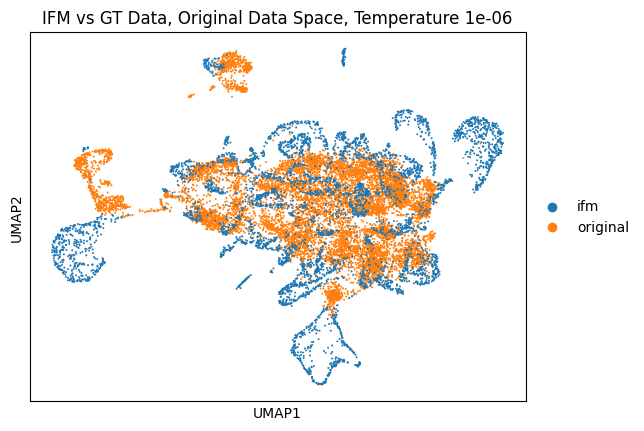

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


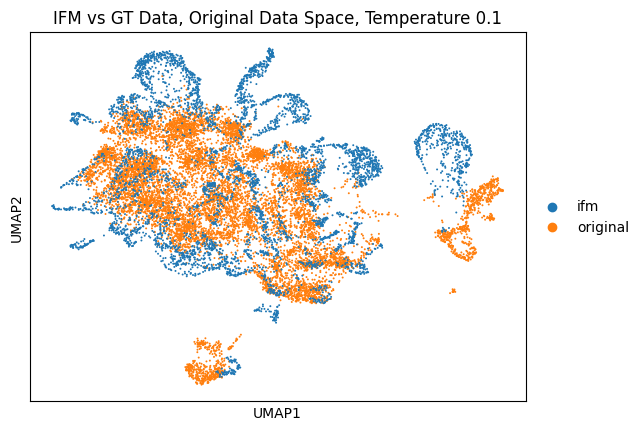

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


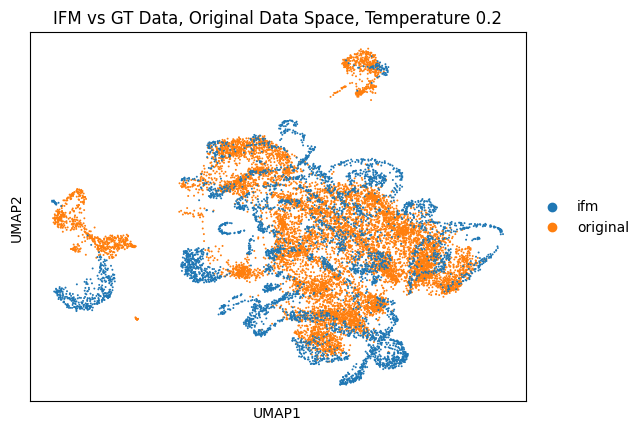

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


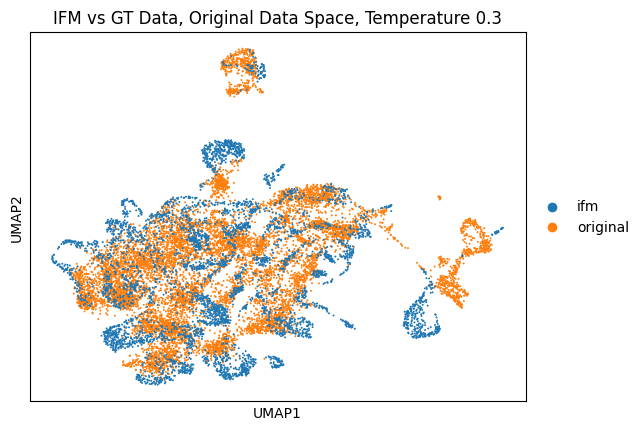

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


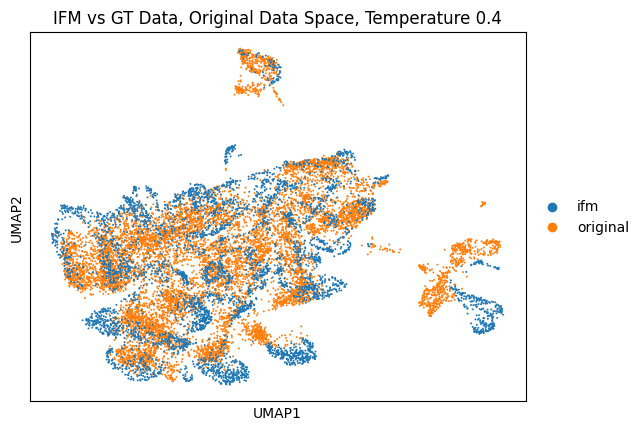

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


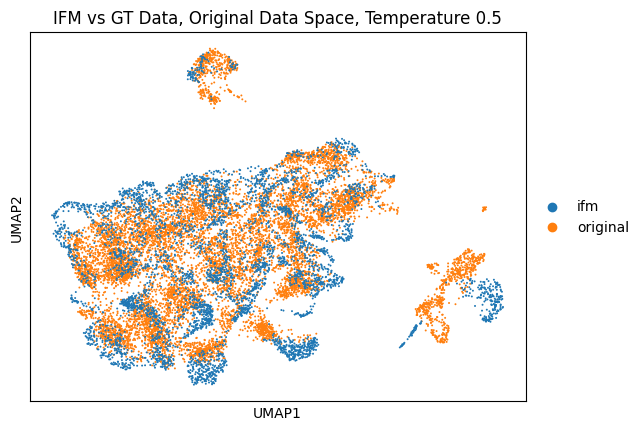

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


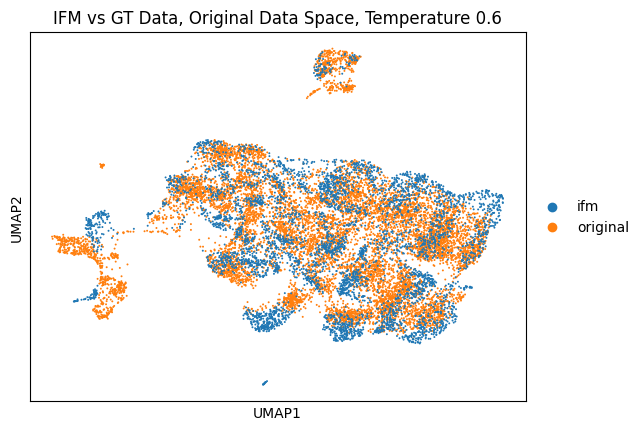

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


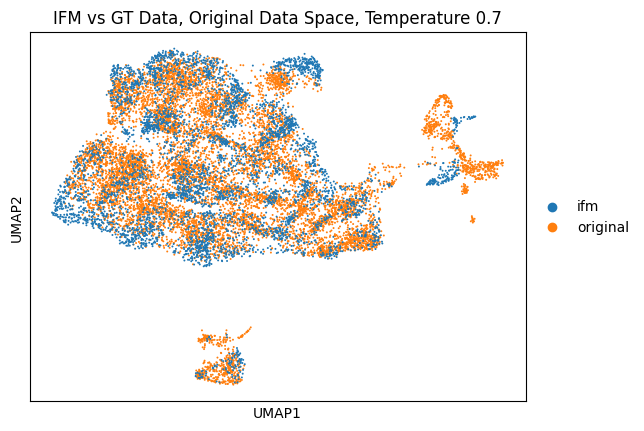

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


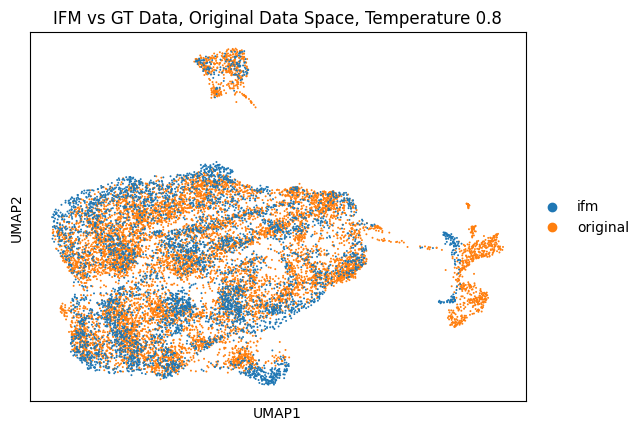

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


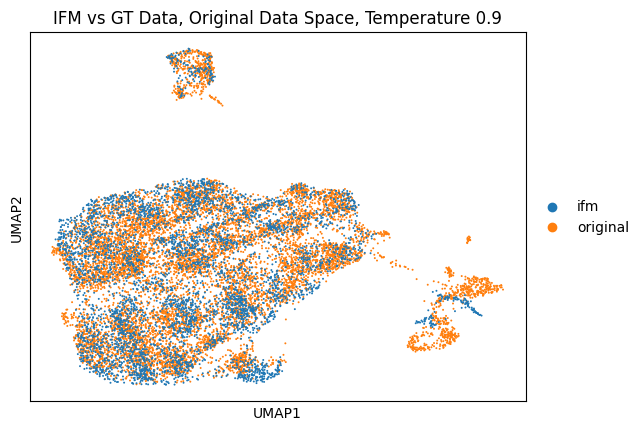

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


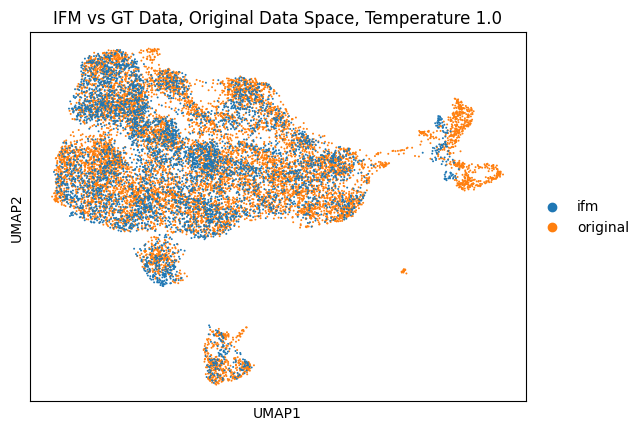

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


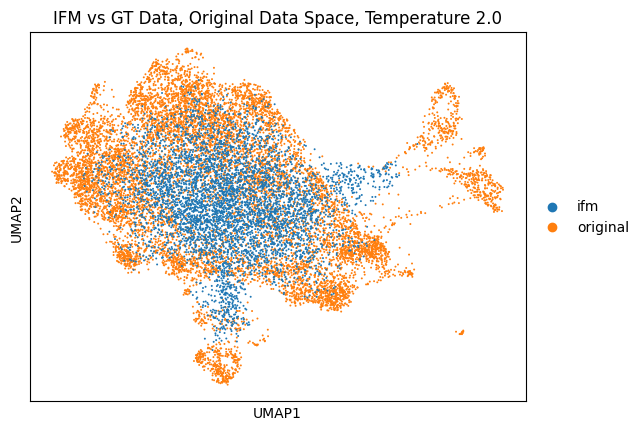

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


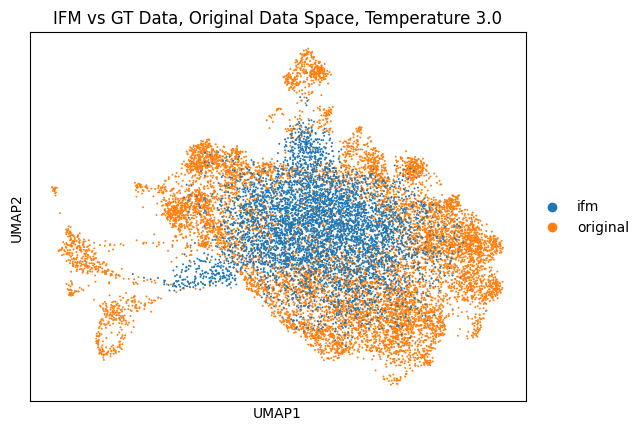

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


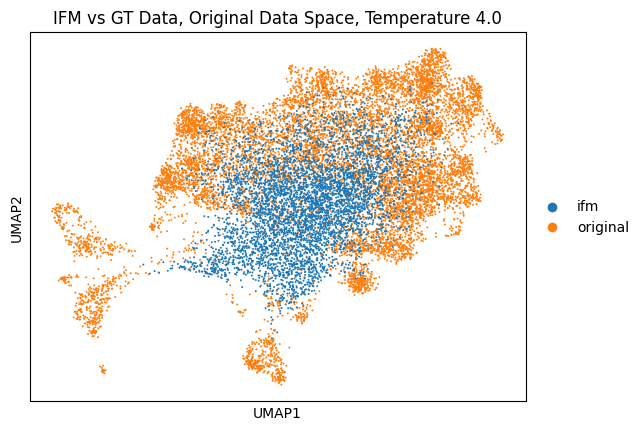

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


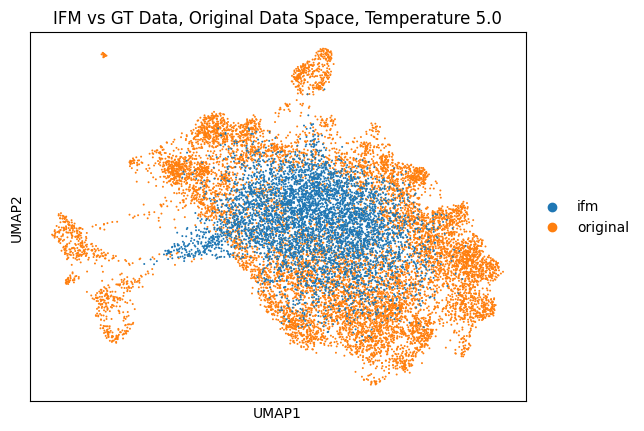

In [15]:
pcs = [i for i in range(2, 20)]
for temp in temp_to_cells:
    cells = temp_to_cells[temp]
    ifm_adata = anndata.AnnData(X=cells)
    ifm_adata.obs['sample'] = ['ifm']*len(cells)
    # simple_sampled_adata = anndata.AnnData(X=dense_array)
    # simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
    # combined_norm_adata = anndata.concat([simple_sampled_adata, ifm_adata])
    
    # sc.settings.figdir = '/home/dfl32/project/ifm/data/temp_data/pca_plots'
    
    # sc.pp.pca(combined_norm_adata)
    # sc.pp.neighbors(combined_norm_adata)
    # sc.tl.umap(combined_norm_adata)
    # sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5, title=f"IFM vs GT Data, PCA Space, Temperature {temp}", save=f"_temp{temp}.png")
    
    ifm_inverse_transformed = pca.inverse_transform(ifm_adata.X)
    print("transform done")
    ifm_inverse_adata = anndata.AnnData(X=ifm_inverse_transformed)
    ifm_inverse_adata.obs['sample'] = ['ifm']*ifm_inverse_transformed.shape[0]
    original_adata = anndata.AnnData(X=expression_data)
    original_adata.obs['sample'] = ['original']*expression_data.shape[0]
    combined_original_adata = anndata.concat([original_adata, ifm_inverse_adata])
    
    # simple_sampled_adata = anndata.AnnData(X=dense_array)
    # simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
    # combined_norm_adata = anndata.concat([simple_sampled_adata, ifm_adata])
    
    sc.settings.figdir = '/home/dfl32/project/ifm/data/temp_data/og_space_plots'
    sc.pp.pca(combined_original_adata)
    print("pca done")
    sc.pp.neighbors(combined_original_adata)
    print("knn done")
    sc.tl.umap(combined_original_adata)
    sc.pl.umap(
        combined_original_adata,
        color=['sample'],
        wspace=0.5,
        title=f"IFM vs GT Data, Original Data Space, Temperature {temp}",
        save=f"_temp{temp}.png"
    )

In [ ]:
temp_to_cells_ipca = {}
temp_to_mmd_ipca = {}
temp_to_wass_ipca = {}

for temp in tqdm(temp_to_cells):
    cells = temp_to_cells[temp]
    ifm_inverse_transformed = pca.inverse_transform(cells)
    temp_to_cells_ipca[temp] = ifm_inverse_transformed
    print("transform done")

    mmd = mmd_rbf(ifm_inverse_transformed, expression_data, gamma=2.0)
    temp_to_mmd_ipca[temp] = mmd
    print(f"Temp {temp} MMD {mmd}")
    wass = compute_wass(ifm_inverse_transformed, expression_data, reg=0.01)
    temp_to_wass_ipca[temp] = wass
    print(f"Temp {temp} Wass {wass}")

save_dir = "/home/dfl32/project/ifm/data/temp_data"
fn = "temp_to_cells_ipca.pickle"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_cells_ipca, f)

fn = "temp_to_wass_ipca.pickle"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_wass_ipca, f)

fn = "temp_to_mmd_ipca.pickle"
save_path = os.path.join(save_dir, fn)

with open(save_path, "wb") as f:
    pickle.dump(temp_to_mmd_ipca, f)



  0%|          | 0/15 [00:00<?, ?it/s]

transform done
Temp 1e-06 MMD 0.012824874371290207


  7%|▋         | 1/15 [1:20:38<18:48:52, 4838.03s/it]

Temp 1e-06 Wass 0.38154385078856157
transform done
Temp 0.1 MMD 0.00976132694631815


 13%|█▎        | 2/15 [2:41:46<17:32:06, 4855.89s/it]

Temp 0.1 Wass 0.37488460920687083
transform done


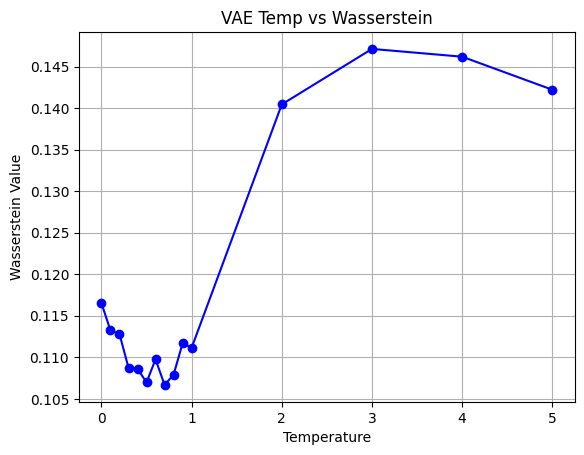

In [109]:
# Extract keys and values
x_values = list(temp_to_mmd.keys())
y_values = list(temp_to_mmd.values())

# Create the line plot
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('VAE Temp vs MMD')
plt.xlabel('Temperature')
plt.ylabel('MMD Value')

# Adding grid
plt.grid(True)

# Display the plot
plt.savefig('/home/dfl32/project/ifm/data/temp_data/temp_to_mmd.png')
plt.close()
# Extract keys and values
x_values = list(temp_to_wass.keys())
y_values = list(temp_to_wass.values())

# Create the line plot
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('VAE Temp vs Wasserstein')
plt.xlabel('Temperature')
plt.ylabel('Wasserstein Value')

# Adding grid
plt.grid(True)

# Display the plot
plt.savefig('/home/dfl32/project/ifm/data/temp_data/temp_to_wass.png')

In [89]:
num_comps = 768
middle_adata = anndata.AnnData(X=middle)
middle_adata.obs['sample'] = ['middle time point']*len(middle_adata)
noise_adata = anndata.AnnData(X=noise)
noise_adata.obs['sample'] = ['noise']*len(noise)
ifm_adata = anndata.AnnData(X=cells[:, :num_comps])
ifm_adata.obs['sample'] = ['ifm']*len(cells)
# target_adata = anndata.AnnData(X=generate_bimodal_samples(cells.shape[0]).numpy())
# target_adata.obs['sample'] = ['targets']*len(cells)
input_output_adata = anndata.concat([noise_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [108]:
1

1

# 2d plots

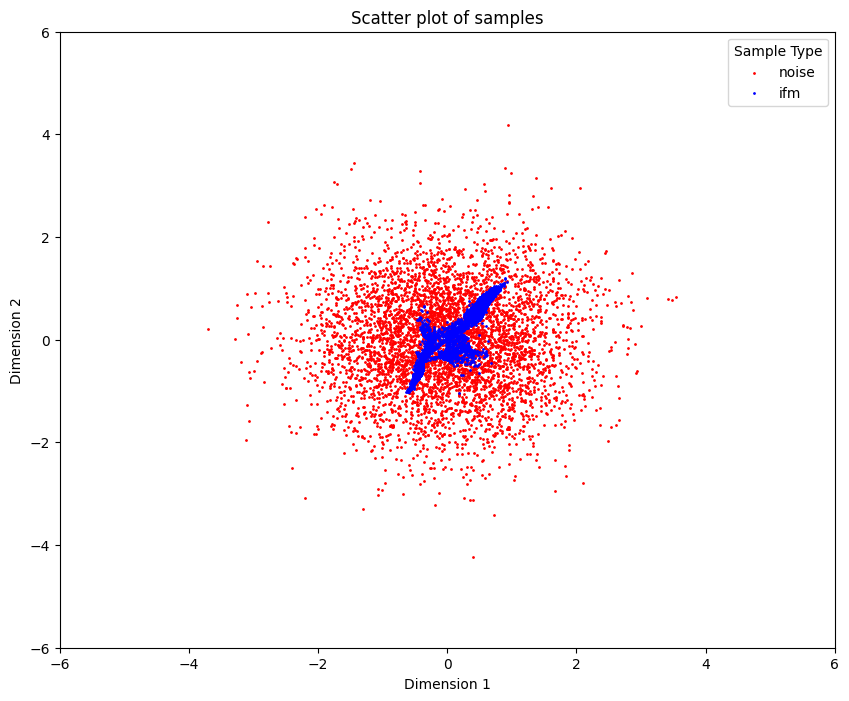

In [86]:
data = input_output_adata.X
# Extract labels for coloring
labels = input_output_adata.obs['sample']

# Map categories to colors
color_map = {'noise': 'red','ifm': 'blue'}
colors = labels.map(color_map)

# Create scatter plot
plt.figure(figsize=(10, 8))
for category, color in color_map.items():
    idx = labels == category
    plt.scatter(data[idx, 0], data[idx, 1], c=color, label=category, alpha=1.0, s=1)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.title('Scatter plot of samples')
plt.legend(title='Sample Type')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


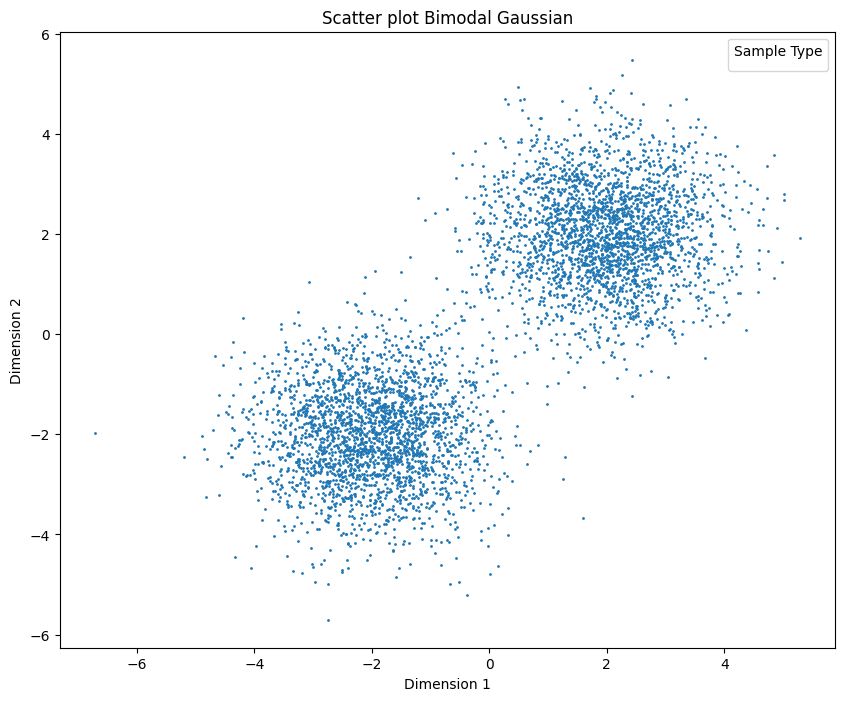

In [12]:
data = generate_bimodal_samples(5000).numpy()

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=1.0, s=1)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot Bimodal Gaussian')
plt.legend(title='Sample Type')
plt.show()

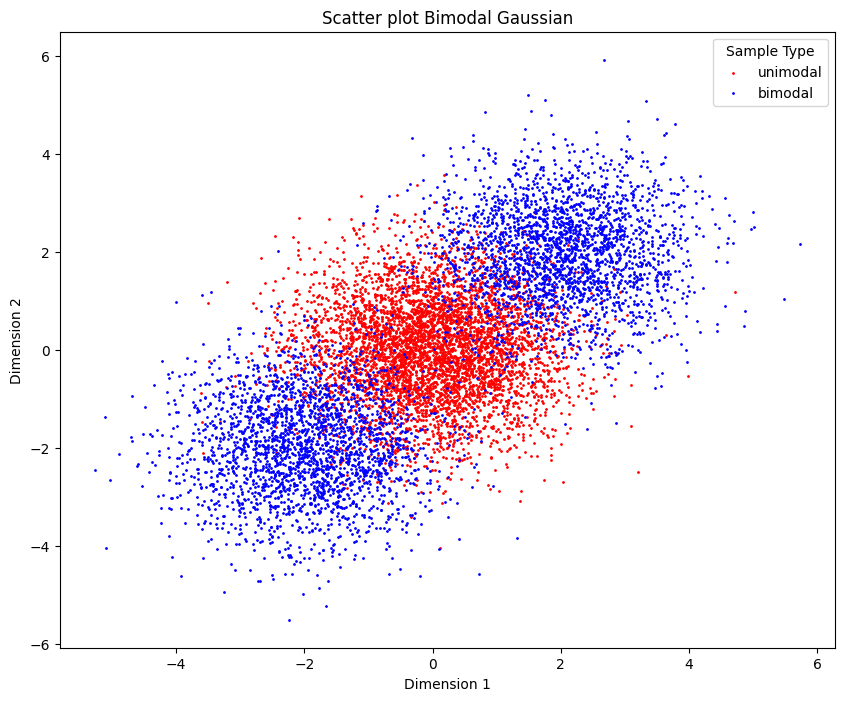

In [18]:
data = generate_bimodal_samples(5000).numpy()

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(noise[:, 0], noise[:, 1], c='red', alpha=1.0, s=1, label='unimodal')
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=1.0, s=1, label='bimodal')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot Bimodal Gaussian')
plt.legend(title='Sample Type')
plt.show()

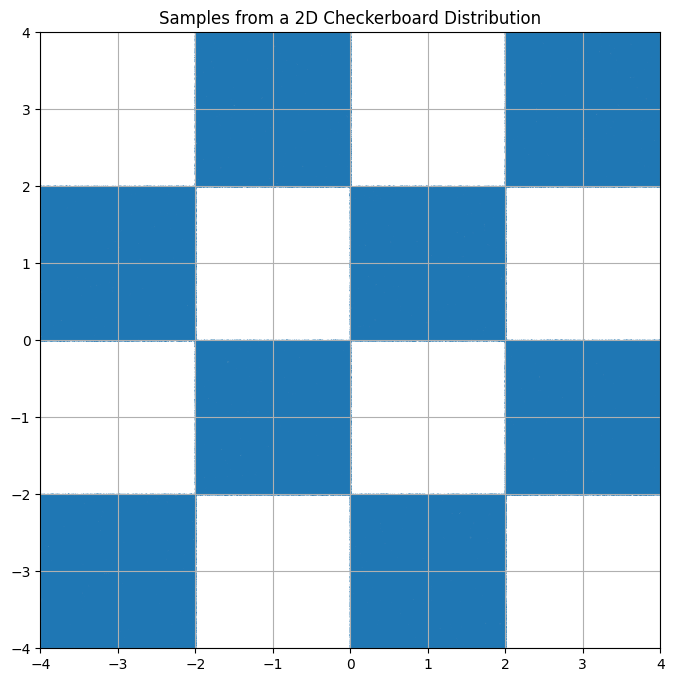

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def generate_checkerboard_samples(num_samples):
    # Initialize array to store samples
    samples = np.zeros((num_samples, 2))
    
    # List of supported squares, each defined by the lower bound corner (x, y)
    supported_squares = []
    for x in range(-4, 4, 2):  # from -4 to 2, stepping by 2
        for y in range(-4, 4, 2):  # from -4 to 2, stepping by 2
            if (x // 2 + y // 2) % 2 == 0:  # checkerboard pattern condition
                supported_squares.append((x, y))
    
    # Generate samples
    for i in range(num_samples):
        # Choose a random square from the supported squares
        square = supported_squares[np.random.randint(len(supported_squares))]
        # Generate a random point within this square
        samples[i, 0] = np.random.uniform(square[0], square[0] + 2)
        samples[i, 1] = np.random.uniform(square[1], square[1] + 2)
    
    return torch.tensor(samples)

# Number of samples to generate
num_samples = 1000000

# Generate samples
samples = generate_checkerboard_samples(num_samples).numpy()

# Plot the samples
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Samples from a 2D Checkerboard Distribution")
plt.grid(True)
plt.show()


# Single-cell plots

In [14]:
dataset = load_from_disk("/home/dfl32/scratch/cinemaot_data/ifm_hf_ds/gaussian_pca768_normFalse_hf_ds")
data_array = np.array(dataset['expr'])

sample_indices = np.random.choice(data_array.shape[0], size=5000, replace=False)

# Subset the AnnData object
dense_array = data_array[sample_indices]

# # Convert to a dense matrix and extract the numpy array
# dense_array = sampled_adata.X.toarray() if issparse(sampled_adata.X) else sampled_adata.X

In [90]:

simple_sampled_adata = anndata.AnnData(X=dense_array[:, :num_comps])
simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
min_val = np.min(simple_sampled_adata.X[simple_sampled_adata.X > 0])
ifm_thresh_adata = ifm_adata.copy()
ifm_thresh_adata.X[ifm_thresh_adata.X < min_val] = 0
combined_thresh_adata = anndata.concat([simple_sampled_adata, ifm_thresh_adata])
combined_norm_adata = anndata.concat([simple_sampled_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


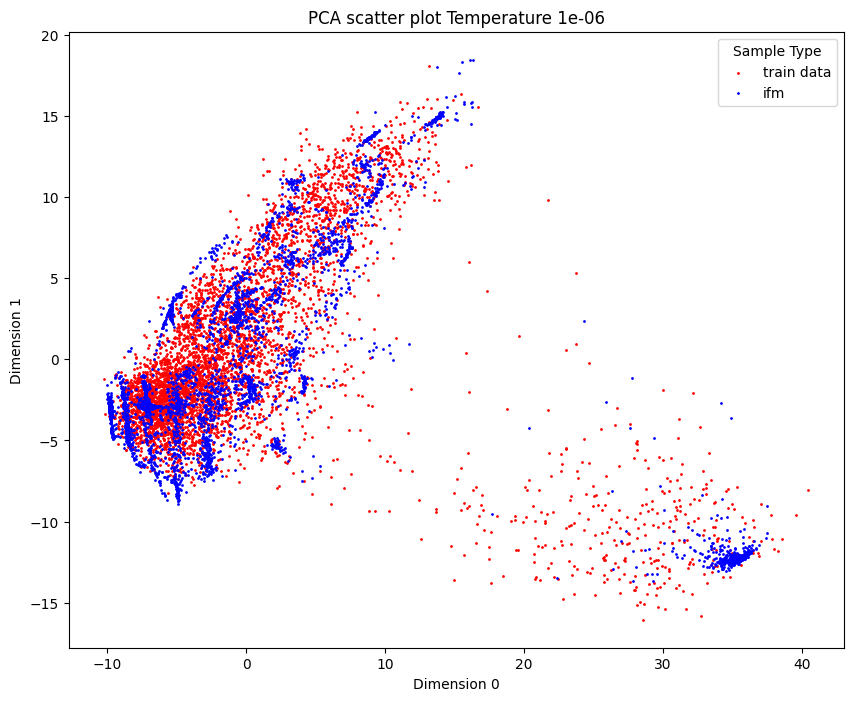

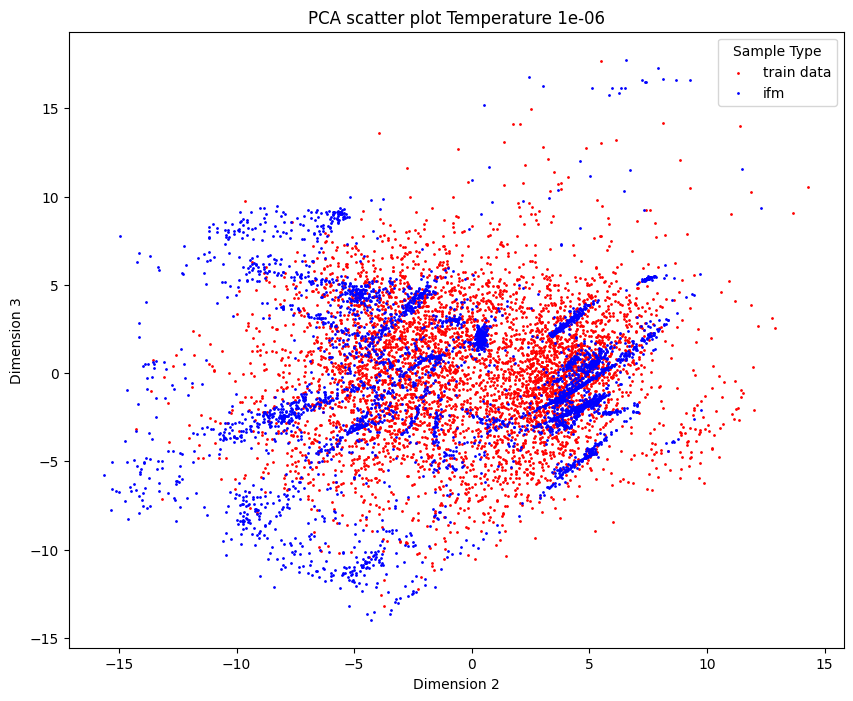

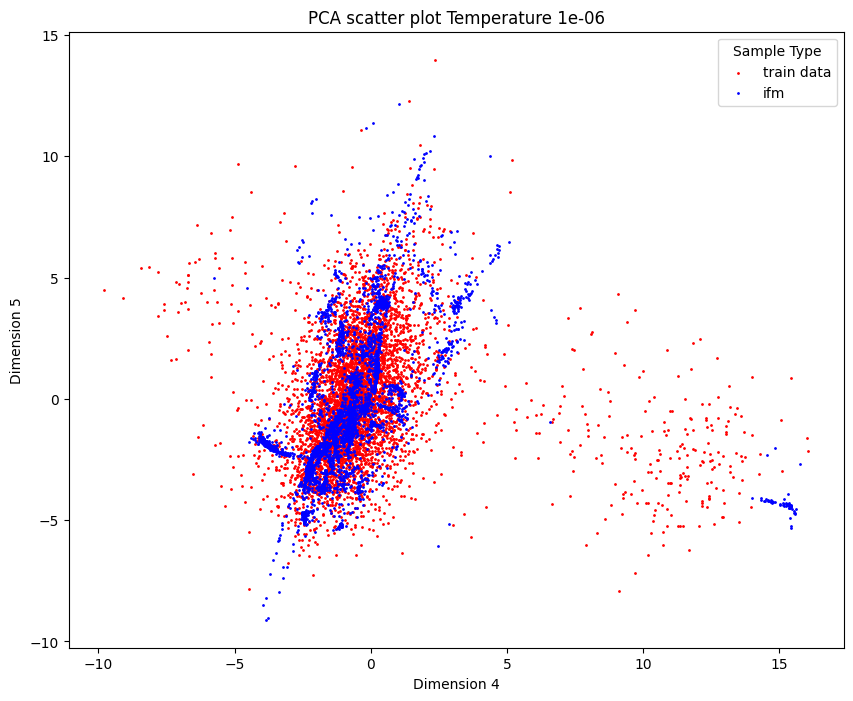

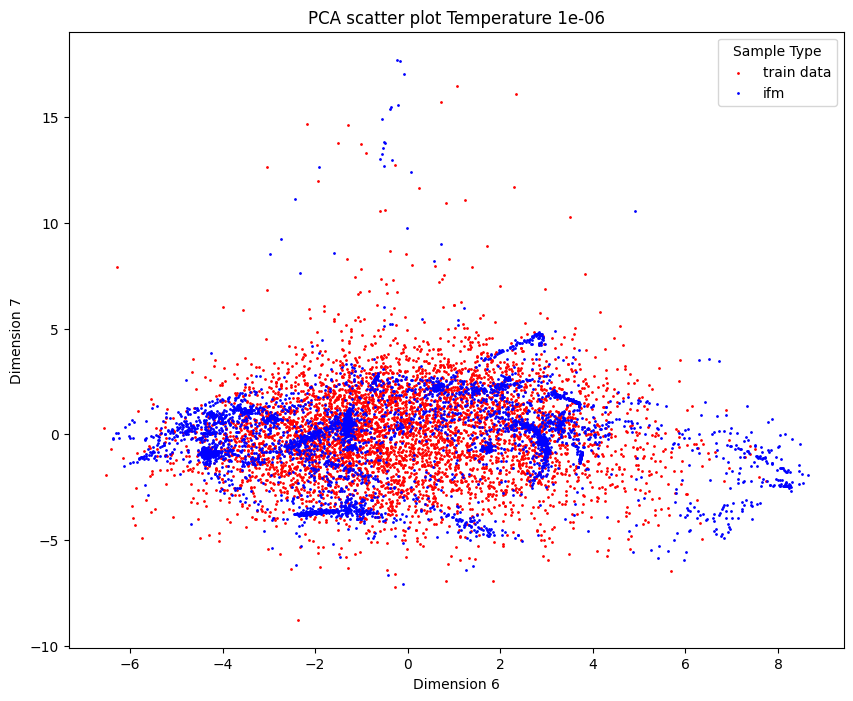

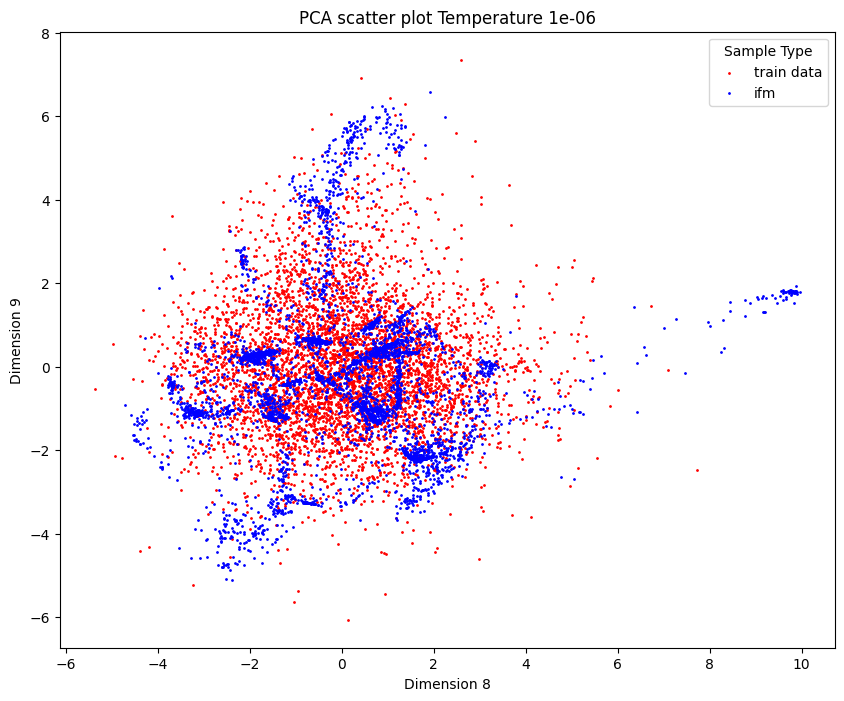

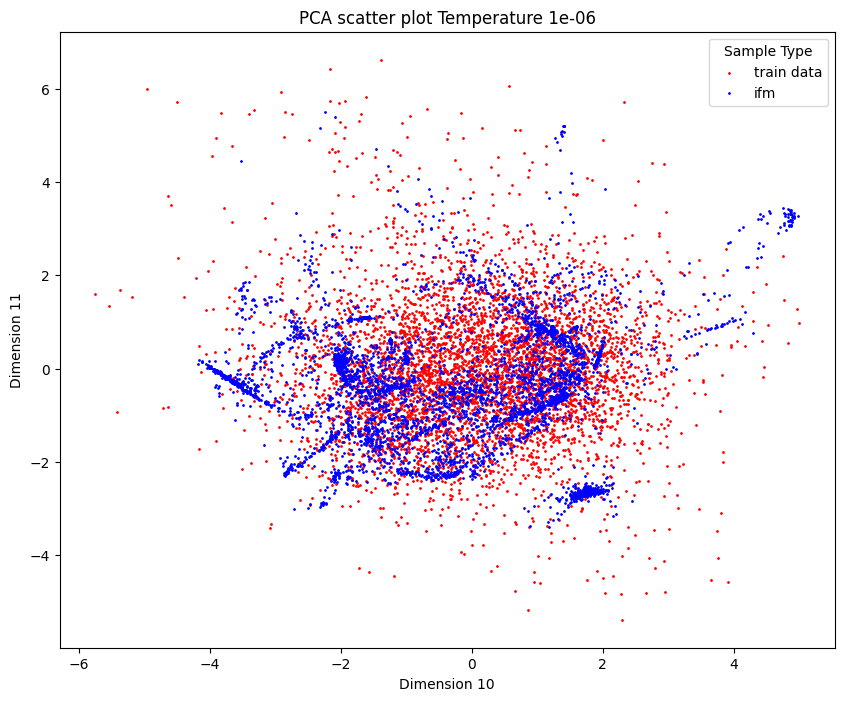

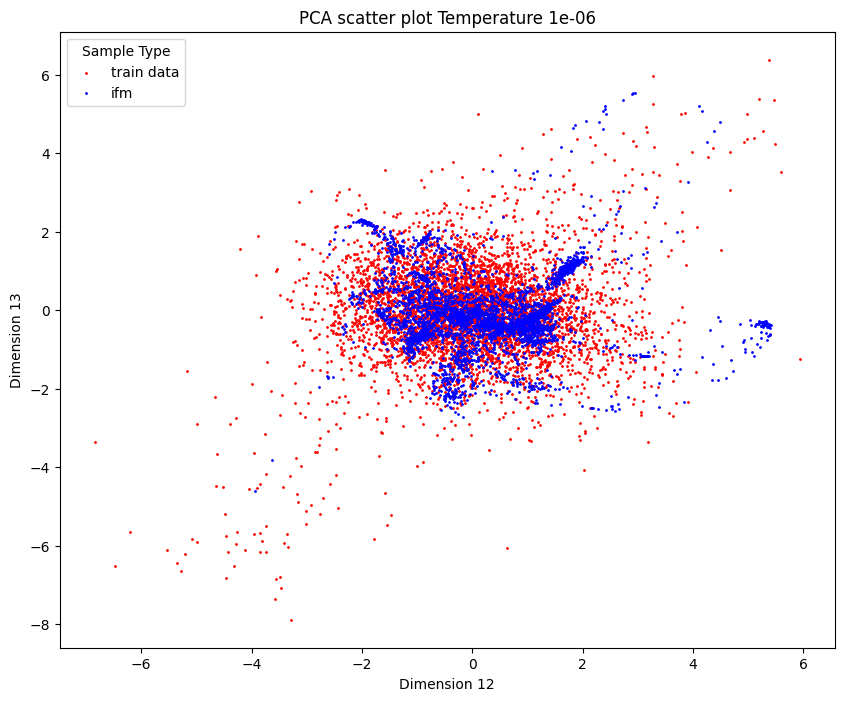

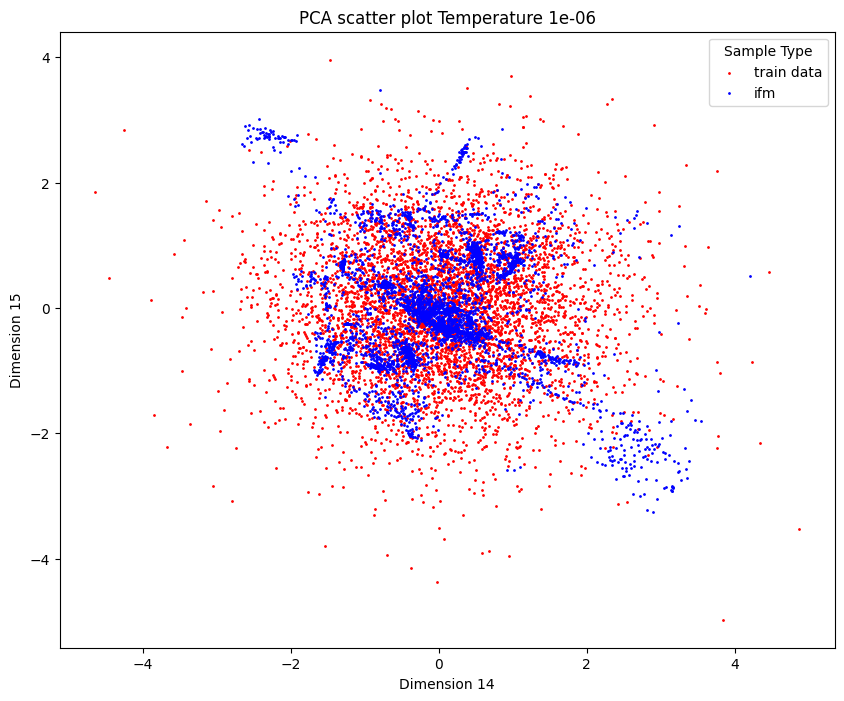

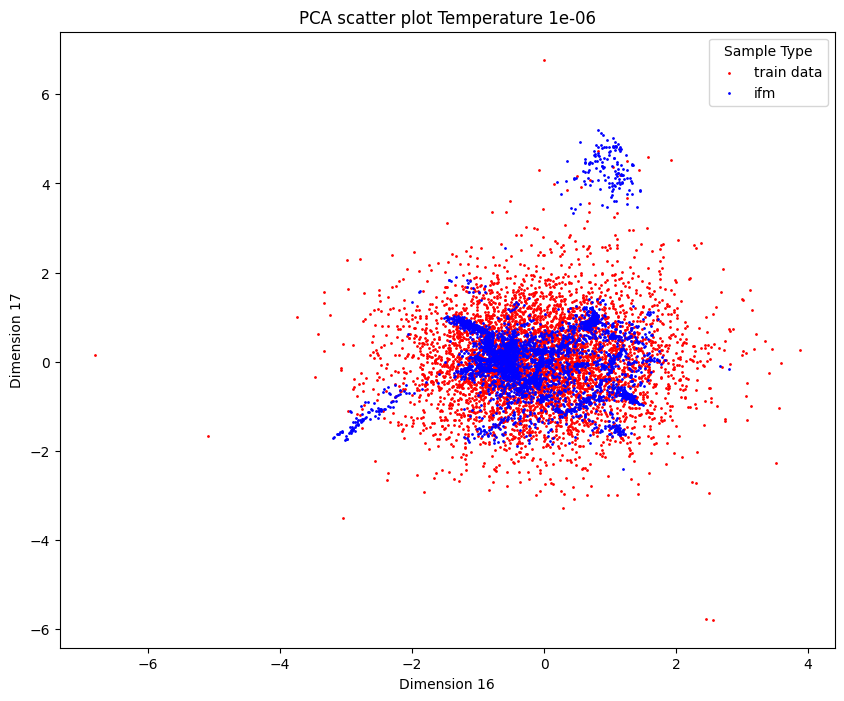

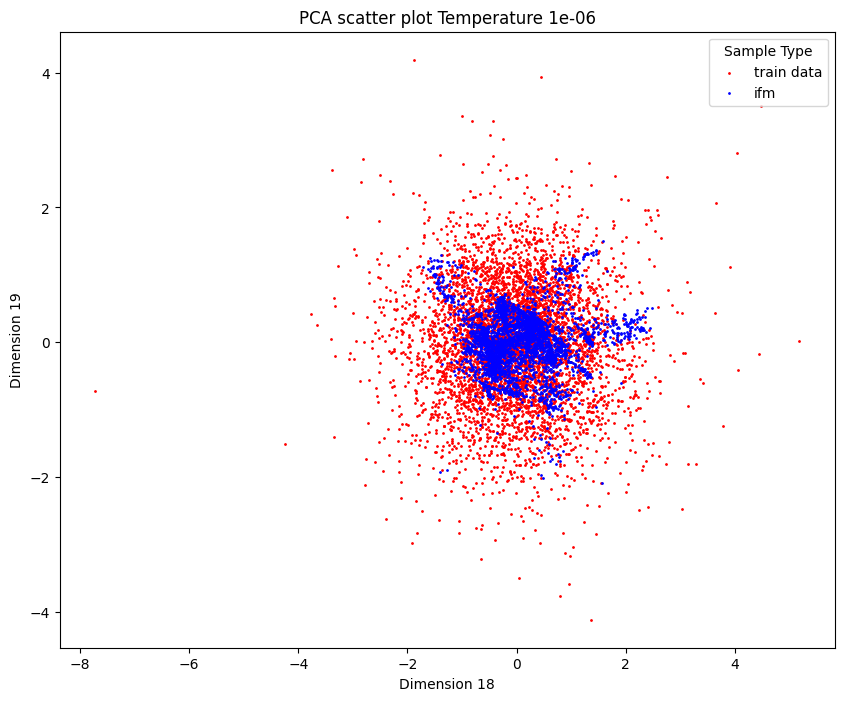

In [91]:
data = combined_norm_adata.X
# Extract labels for coloring
labels = combined_norm_adata.obs['sample']

# Map categories to colors
color_map = {'train data': 'red','ifm': 'blue'}
colors = labels.map(color_map)

# Create scatter plot
for i in range(10):
    dim_1 = i*2
    dim_2 = i*2 + 1
    plt.figure(figsize=(10, 8))
    for category, color in color_map.items():
        idx = labels == category
        plt.scatter(data[idx, dim_1], data[idx, dim_2], c=color, label=category, alpha=1.0, s=1)
    
    plt.xlabel(f'Dimension {dim_1}')
    plt.ylabel(f'Dimension {dim_2}')
    # plt.xlim(-6, 6)
    # plt.ylim(-6, 6)
    plt.title(f'PCA scatter plot Temperature {temperature}')
    plt.legend(title='Sample Type')
    plt.show()

In [82]:
combined_norm_adata

AnnData object with n_obs × n_vars = 10000 × 768
    obs: 'sample'

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


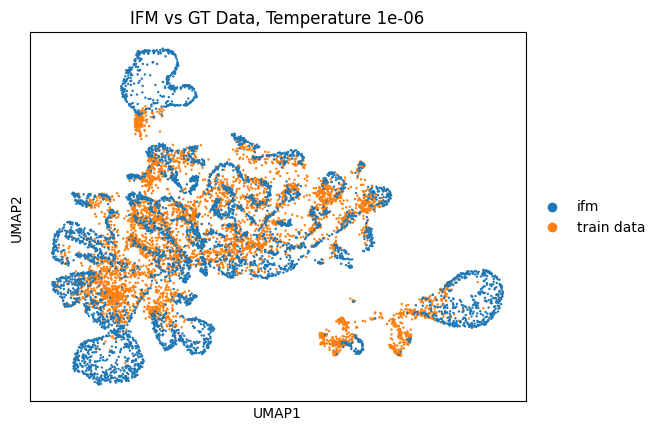

In [92]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5, title=f"IFM vs GT Data, Temperature {temperature}")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


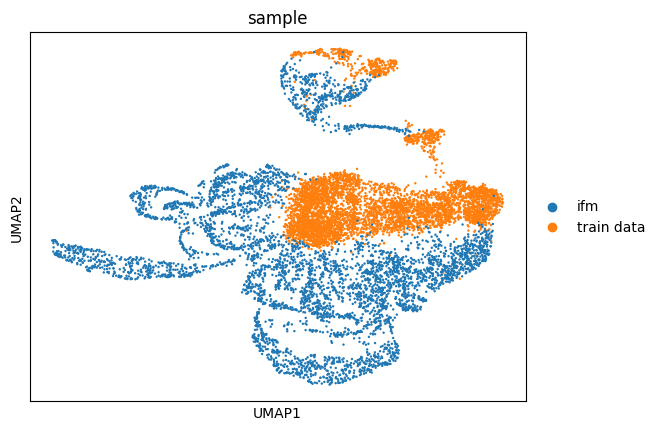

In [22]:
metric = 'cosine'

sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata, metric=metric)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


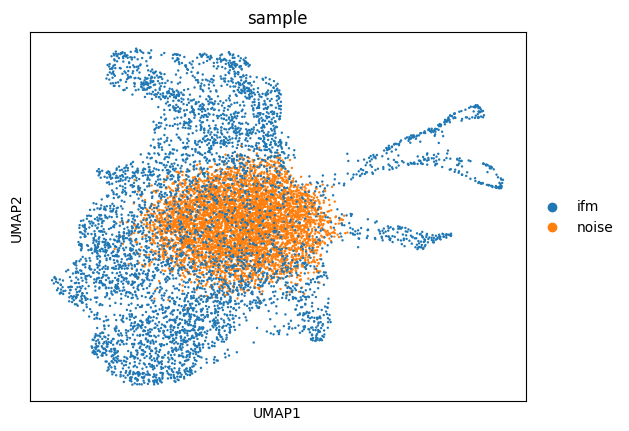

In [40]:
sc.pp.pca(input_output_adata)
sc.pp.neighbors(input_output_adata)
sc.tl.umap(input_output_adata)
sc.pl.umap(input_output_adata, color=['sample'], wspace=0.5)

In [60]:
noise_gen_gt_adata = anndata.concat([simple_sampled_adata, ifm_adata, noise_adata, middle_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
# Calculate the mean along the last axis (columns)
mean_row = np.mean(adata.X, axis=0)

# Reshape mean_row to make it a 2D array with one row
mean_row = mean_row.reshape(1, -1)

# Repeat the mean_row for the same number of times as there are rows in the original array
repeated_mean_array = np.repeat(mean_row, dense_array.shape[0], axis=0)

# Generate Gaussian noise with mean 0 and standard deviation 0.1
noise = np.random.normal(0, 0.1, repeated_mean_array.shape)

# Add the noise to the repeated_mean_array
noisy_array = repeated_mean_array + noise

mean_adata = anndata.AnnData(X=noisy_array)
mean_adata.obs['sample'] = ['mean']*len(mean_adata)

combined_mean_ifm_adata = anndata.concat([mean_adata, ifm_adata])


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [52]:
all_adata = anndata.concat([simple_sampled_adata, mean_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


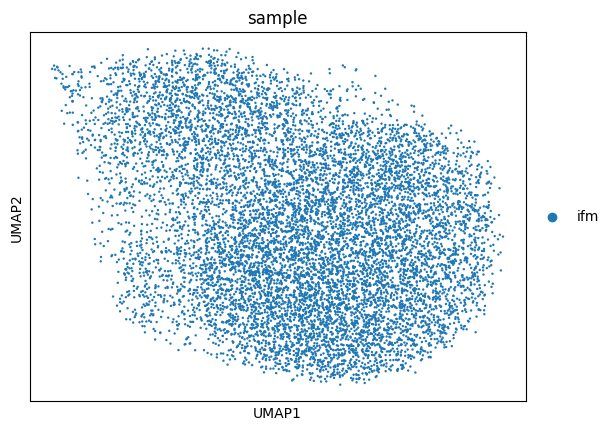

In [12]:
sc.pp.pca(ifm_adata)
sc.pp.neighbors(ifm_adata)
sc.tl.umap(ifm_adata)
sc.pl.umap(ifm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


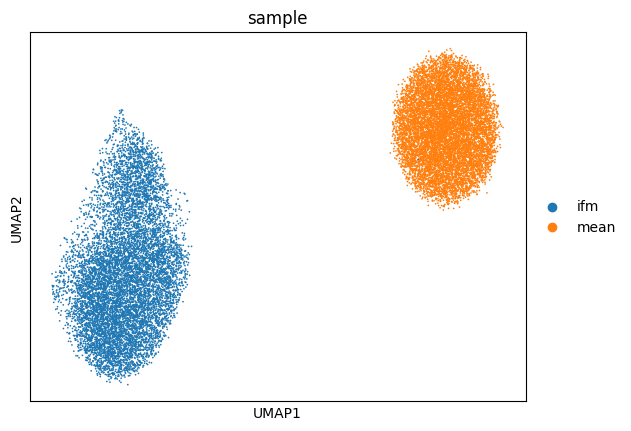

In [13]:
sc.pp.pca(combined_mean_ifm_adata)
sc.pp.neighbors(combined_mean_ifm_adata)
sc.tl.umap(combined_mean_ifm_adata)
sc.pl.umap(combined_mean_ifm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


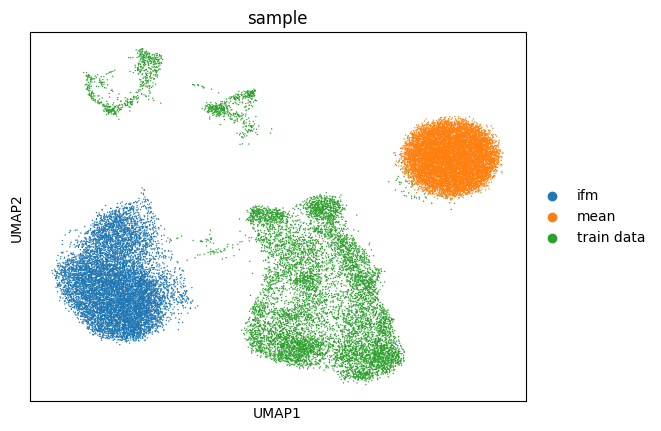

In [14]:
sc.pp.pca(all_adata)
sc.pp.neighbors(all_adata)
sc.tl.umap(all_adata)
sc.pl.umap(all_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


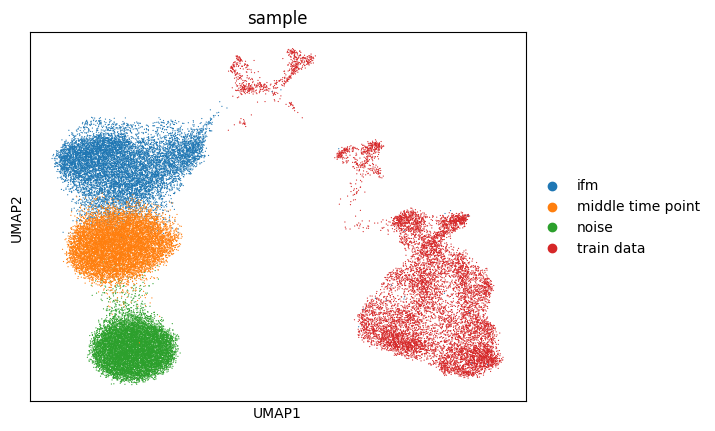

In [23]:
sc.pp.pca(noise_gen_gt_adata)
sc.pp.neighbors(noise_gen_gt_adata)
sc.tl.umap(noise_gen_gt_adata)
sc.pl.umap(noise_gen_gt_adata, color=['sample'], wspace=0.5)